# Data Processing and Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import src.data_proc as data_proc

In [3]:
%%time
# Load in the data
train_2016 = pd.read_csv("data/train_2016_v2.csv")
prop = pd.read_csv("data/properties_2016.csv", dtype={
    'propertycountylandusecode': str,
    'hashottuborspa': str,
    'propertyzoningdesc': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str
})

# Parse the flag attributes
def convert_true_to_float(df, col):
    df.loc[df[col] == 'true', col] = '1'
    df.loc[df[col] == 'Y', col] = '1'
    df[col] = df[col].astype(float)

for col in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    convert_true_to_float(prop, col)

CPU times: user 19.7 s, sys: 3.84 s, total: 23.5 s
Wall time: 23.6 s


In [4]:
# Take a quick look at the data
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
prop.head(30)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,NaN,2400.0,NaN,NaN,2400.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171873.0,-118380906.0,2500.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAC4,6.037125e+07,12447.0,3101.0,46795.0,96446.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1943.0,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34131929.0,-118351474.0,NaN,NaN,NaN,NaN,NaN,NaN,010V,260.0,LAC2,6.037144e+07,12447.0,3101.0,274049.0,96049.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3611.0,NaN,NaN,3611.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171345.0,-118314900.0,5333.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,BUC4YY,6.037311e+07,396054.0,3101.0,NaN,96434.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1946.0,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34218210.0,-118331311.0,145865.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,BUR1*,6.037310e+07,396054.0,3101.0,NaN,96436.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,3754.0,NaN,NaN,3754.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34289776.0,-118432085.0,7494.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,SFC2*,6.037320e+07,47547.0,3101.0,NaN,96366.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1978.0,1.0

In [6]:
print("Number of transaction records: {}".format(len(train_2016)))
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))

Number of transaction records: 90275
Number of properties: 2985217
Number of property features: 57


In [7]:
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)
print(prop.info())
prop.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                   int64
cooling_id                 category
architecture_style_id      category
basement_sqft              float32
bathroom_cnt               float32
bedroom_cnt                float32
framing_id                 category
quality_id                 category
bathroom_cnt_calc          float32
deck_id                    float32
floor1_sqft                float32
finished_area_sqft_calc    float32
finished_area_sqft         float32
perimeter_area             float32
total_area                 float32
floor1_sqft_unk            float32
base_total_area            float32
fips                       category
fireplace_cnt              float32
bathroom_full_cnt          float32
garage_cnt                 float32
garage_sqft                float32
spa_flag                   float32
heating_id                 category
latitude                   float32
longitud

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,10754147,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,238,NaN,60378004.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,230,LCA11*,60378000.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60377032.0,51617.0,1815,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,6,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60371412.0,12447.0,1815,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,-1,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAM1,60371232.0,12447.0,1815,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN
5,10898347,-1,-1,NaN,0.0,0.0,3,6,NaN,NaN,NaN,2400.0,NaN,NaN,2400.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171872.0,-118380904.0,2500.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAC4,60371252.0,12447.0,1815,46795.0,96446.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1943.0,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.280029,NaN,NaN,NaN
6,10933547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34131928.0,-118351472.0,NaN,NaN,NaN,NaN,NaN,NaN,010V,229,LAC2,60371436.0,12447.0,1815,274049.0,96049.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.339844,NaN,NaN,NaN
7,10940747,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,3611.0,NaN,NaN,3611.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34171344.0,-118314896.0,5333.0,NaN,NaN,NaN,NaN,NaN,1210,0,BUC4YY,60373108.0,396054.0,1815,NaN,96434.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1946.0,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.839844,NaN,NaN,NaN
8,10954547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34218208.0,-118331312.0,145865.0,NaN,NaN,NaN,NaN,NaN,010D,238,BUR1*,60373100.0,396054.0,1815,NaN,96436.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,-1,-1,NaN,0.0,0.0,2,6,NaN,NaN,NaN,3754.0,NaN,NaN,3754.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34289776.0,-118432088.0,7494.0,NaN,NaN,NaN,NaN,NaN,1210,0,SFC2*,60373204.0,47547.0,1815,NaN,96366.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1978.0,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.760010,NaN,NaN,NaN


In [8]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')

# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)
train_2016.head(30)

parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999889227360842
tax_parcel: 0.9999889227360842
tax_land: 0.9999889227360842
tax_property: 0.9999335364165052
region_zip: 0.9996122957629465
tax_structure: 0.9957906397119911
census_2: 0.9932982553309333
finished_area_sqft_calc: 0.9926779285516477
year_built: 0.9916255884796455
bathroom_cnt_calc: 0.9869066740515092
bathroom_full_cnt: 0.9869066740515092
city_id: 0.9800276931597895
finished_area_sqft: 0.948169482137912
lot_sqft: 0.8875657712545001
unit_cnt: 0.646391581279424
zoning_description: 0.6459484907227915
quality_id: 0.6354361672666852
heating_id: 0.6212129603987815
neighborhood_id: 0.39891442813625033
garage_cnt: 0.3316200498476876
garage_sqft: 0.3316200498476876
cooling_id: 0.318814732761008
story_cnt: 0.22785931874826917
pool_cnt: 0.19829410135696482
pool_u

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983

In [9]:
# Prepare data for LightGBM
lgb_label = train_2016.logerror.astype(np.float32)

# Drop features that are not useful or too messy
def drop_features(features):
    unused_feature_list = ['parcelid', 'logerror']  # not features
    unused_feature_list += ['tax_year']  # Not useful
    unused_feature_list += ['framing_id', 'construction_id', 'deck_id', 'pool_unk_1', 'pool_unk_2',
                           'architecture_style_id', 'story_id', 'perimeter_area', 'pool_total_size'] # too many missing
    unused_feature_list += ['latitude', 'longitude']  # Maybe?
    unused_feature_list += ['county_landuse_code', 'zoning_description']  # cannot be used directly
    unused_feature_list += ['transactiondate']  # Should definitely extract feature from this
    return features.drop(unused_feature_list, axis=1, errors='ignore')

lgb_features = drop_features(train_2016)
print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 43


,cooling_id,basement_sqft,bathroom_cnt,bedroom_cnt,quality_id,bathroom_cnt_calc,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,lot_sqft,pool_cnt,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,0,NaN,2.0,3.0,3,2.0,NaN,1684.0,1684.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,7528.0,NaN,NaN,230,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,-1,NaN,3.5,4.0,-1,3.5,NaN,2263.0,2263.0,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,3643.0,NaN,NaN,230,60590524.0,32380.0,0,NaN,96962.0,0.0,1.0,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,239071.0,10153.019531,NaN,NaN,NaN
2,0,NaN,3.0,2.0,3,3.0,NaN,2217.0,2217.0,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,11423.0,NaN,NaN,230,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,0,NaN,2.0,2.0,3,2.0,NaN,839.0,839.0,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,70859.0,NaN,NaN,235,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,-1,NaN,2.5,4.0,-1,2.5,NaN,2283.0,2283.0,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,6000.0,1.0,1.0,230,60590424.0,17686.0,0,NaN,96961.0,8.0,1.0,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,0,NaN,4.0,4.0,0,4.0,NaN,3067.0,3067.0,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,2708.0,NaN,NaN,230,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,-1,NaN,1.0,2.0,6,1.0,NaN,1297.0,1297.0,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,6677.0,NaN,NaN,230,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,-1,NaN,2.5,3.0,-1,2.5,853.0,1763.0,1763.0,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,NaN,NaN,NaN,235,61110032.0,13150.0,775,NaN,97101.0,6.0,1.0,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,-1,NaN,1.0,2.0,-1,1.0,NaN,796.0,796.0,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,NaN,NaN,NaN,235,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,-1,NaN,2.0,2.0,-1,2.0,NaN,1260.0,1260.0,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,NaN,NaN,NaN,235,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,80983.0,1940.260010,NaN,NaN,6.059063e+13


In [10]:
# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (67706, 43)
y_train shape: (67706,)
X_val shape: (22569, 43)
y_val shape: (22569,)


In [11]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 1500
params['learning_rate'] = 0.001  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 512  # max number of leaves in one tree (default 31)
params['min_data'] = 175  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.7    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 10.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [12]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 4, 12, 18, 22, 25]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0683559	val's l1: 0.0688178
Training until validation scores don't improve for 20 rounds.
[2]	train's l1: 0.0683534	val's l1: 0.0688162
[3]	train's l1: 0.0683506	val's l1: 0.0688145
[4]	train's l1: 0.0683478	val's l1: 0.0688126
[5]	train's l1: 0.0683445	val's l1: 0.0688101
[6]	train's l1: 0.0683418	val's l1: 0.0688084
[7]	train's l1: 0.0683384	val's l1: 0.068806
[8]	train's l1: 0.0683352	val's l1: 0.0688037
[9]	train's l1: 0.0683321	val's l1: 0.0688015
[10]	train's l1: 0.0683294	val's l1: 0.0688
[11]	train's l1: 0.0683265	val's l1: 0.068798
[12]	train's l1: 0.0683236	val's l1: 0.0687958
[13]	train's l1: 0.0683211	val's l1: 0.0687943
[14]	train's l1: 0.0683179	val's l1: 0.0687917
[15]	train's l1: 0.0683151	val's l1: 0.0687902
[16]	train's l1: 0.0683126	val's l1: 0.0687886
[17]	train's l1: 0.0683094	val's l1: 0.0687863
[18]	train's l1: 0.0683068	val's l1: 0.0687851
[19]	train's l1: 0.0683037	val's l1: 0.0687828
[20]	train's l1: 0.0683005	val's l1: 0.0687804
[21]	train's

[174]	train's l1: 0.0678903	val's l1: 0.0685187
[175]	train's l1: 0.0678876	val's l1: 0.0685172
[176]	train's l1: 0.067885	val's l1: 0.0685158
[177]	train's l1: 0.0678823	val's l1: 0.068514
[178]	train's l1: 0.06788	val's l1: 0.0685124
[179]	train's l1: 0.0678776	val's l1: 0.0685111
[180]	train's l1: 0.0678758	val's l1: 0.0685098
[181]	train's l1: 0.0678736	val's l1: 0.0685086
[182]	train's l1: 0.067871	val's l1: 0.0685069
[183]	train's l1: 0.067869	val's l1: 0.0685055
[184]	train's l1: 0.0678667	val's l1: 0.068504
[185]	train's l1: 0.0678646	val's l1: 0.068503
[186]	train's l1: 0.0678621	val's l1: 0.0685012
[187]	train's l1: 0.0678599	val's l1: 0.0684998
[188]	train's l1: 0.0678574	val's l1: 0.0684982
[189]	train's l1: 0.0678548	val's l1: 0.0684967
[190]	train's l1: 0.0678524	val's l1: 0.0684951
[191]	train's l1: 0.0678502	val's l1: 0.0684941
[192]	train's l1: 0.067848	val's l1: 0.0684929
[193]	train's l1: 0.0678456	val's l1: 0.0684917
[194]	train's l1: 0.0678435	val's l1: 0.068491
[1

[358]	train's l1: 0.0674999	val's l1: 0.0683024
[359]	train's l1: 0.0674982	val's l1: 0.0683015
[360]	train's l1: 0.0674963	val's l1: 0.0683004
[361]	train's l1: 0.0674945	val's l1: 0.0682997
[362]	train's l1: 0.0674926	val's l1: 0.0682985
[363]	train's l1: 0.0674907	val's l1: 0.0682973
[364]	train's l1: 0.0674889	val's l1: 0.0682963
[365]	train's l1: 0.0674869	val's l1: 0.068295
[366]	train's l1: 0.0674849	val's l1: 0.0682937
[367]	train's l1: 0.067483	val's l1: 0.0682925
[368]	train's l1: 0.0674809	val's l1: 0.0682912
[369]	train's l1: 0.0674792	val's l1: 0.0682904
[370]	train's l1: 0.0674774	val's l1: 0.0682896
[371]	train's l1: 0.0674757	val's l1: 0.068289
[372]	train's l1: 0.0674738	val's l1: 0.068288
[373]	train's l1: 0.067472	val's l1: 0.0682869
[374]	train's l1: 0.0674701	val's l1: 0.0682861
[375]	train's l1: 0.0674681	val's l1: 0.068285
[376]	train's l1: 0.0674665	val's l1: 0.0682841
[377]	train's l1: 0.0674647	val's l1: 0.0682831
[378]	train's l1: 0.0674631	val's l1: 0.068282

[542]	train's l1: 0.0671914	val's l1: 0.0681669
[543]	train's l1: 0.0671899	val's l1: 0.068166
[544]	train's l1: 0.0671883	val's l1: 0.0681654
[545]	train's l1: 0.0671866	val's l1: 0.0681646
[546]	train's l1: 0.0671851	val's l1: 0.0681639
[547]	train's l1: 0.0671836	val's l1: 0.0681635
[548]	train's l1: 0.0671818	val's l1: 0.0681628
[549]	train's l1: 0.0671803	val's l1: 0.0681622
[550]	train's l1: 0.0671788	val's l1: 0.0681617
[551]	train's l1: 0.0671775	val's l1: 0.0681614
[552]	train's l1: 0.0671759	val's l1: 0.0681608
[553]	train's l1: 0.0671744	val's l1: 0.0681605
[554]	train's l1: 0.0671729	val's l1: 0.0681598
[555]	train's l1: 0.0671716	val's l1: 0.0681596
[556]	train's l1: 0.0671701	val's l1: 0.0681589
[557]	train's l1: 0.0671686	val's l1: 0.0681583
[558]	train's l1: 0.0671671	val's l1: 0.0681576
[559]	train's l1: 0.067166	val's l1: 0.0681572
[560]	train's l1: 0.0671646	val's l1: 0.0681566
[561]	train's l1: 0.0671632	val's l1: 0.0681563
[562]	train's l1: 0.0671618	val's l1: 0.06

[721]	train's l1: 0.0669473	val's l1: 0.0680829
[722]	train's l1: 0.0669459	val's l1: 0.0680824
[723]	train's l1: 0.0669446	val's l1: 0.068082
[724]	train's l1: 0.0669433	val's l1: 0.0680814
[725]	train's l1: 0.0669418	val's l1: 0.068081
[726]	train's l1: 0.0669405	val's l1: 0.0680806
[727]	train's l1: 0.0669393	val's l1: 0.0680805
[728]	train's l1: 0.066938	val's l1: 0.06808
[729]	train's l1: 0.0669366	val's l1: 0.0680796
[730]	train's l1: 0.0669353	val's l1: 0.0680794
[731]	train's l1: 0.0669338	val's l1: 0.0680788
[732]	train's l1: 0.0669326	val's l1: 0.0680783
[733]	train's l1: 0.0669313	val's l1: 0.0680777
[734]	train's l1: 0.0669301	val's l1: 0.0680774
[735]	train's l1: 0.0669287	val's l1: 0.0680767
[736]	train's l1: 0.0669273	val's l1: 0.0680764
[737]	train's l1: 0.0669262	val's l1: 0.0680762
[738]	train's l1: 0.0669248	val's l1: 0.0680758
[739]	train's l1: 0.0669236	val's l1: 0.0680755
[740]	train's l1: 0.0669223	val's l1: 0.068075
[741]	train's l1: 0.0669209	val's l1: 0.068074

[899]	train's l1: 0.0667475	val's l1: 0.0680408
[900]	train's l1: 0.0667464	val's l1: 0.0680406
[901]	train's l1: 0.0667453	val's l1: 0.0680405
[902]	train's l1: 0.0667443	val's l1: 0.0680402
[903]	train's l1: 0.0667433	val's l1: 0.0680398
[904]	train's l1: 0.0667422	val's l1: 0.0680397
[905]	train's l1: 0.0667412	val's l1: 0.0680398
[906]	train's l1: 0.0667401	val's l1: 0.0680398
[907]	train's l1: 0.0667392	val's l1: 0.0680395
[908]	train's l1: 0.066738	val's l1: 0.0680394
[909]	train's l1: 0.066737	val's l1: 0.0680393
[910]	train's l1: 0.0667361	val's l1: 0.0680391
[911]	train's l1: 0.0667351	val's l1: 0.068039
[912]	train's l1: 0.0667339	val's l1: 0.0680388
[913]	train's l1: 0.0667328	val's l1: 0.0680388
[914]	train's l1: 0.0667318	val's l1: 0.0680387
[915]	train's l1: 0.0667308	val's l1: 0.0680387
[916]	train's l1: 0.0667297	val's l1: 0.0680386
[917]	train's l1: 0.0667287	val's l1: 0.0680386
[918]	train's l1: 0.0667277	val's l1: 0.0680386
[919]	train's l1: 0.0667269	val's l1: 0.068

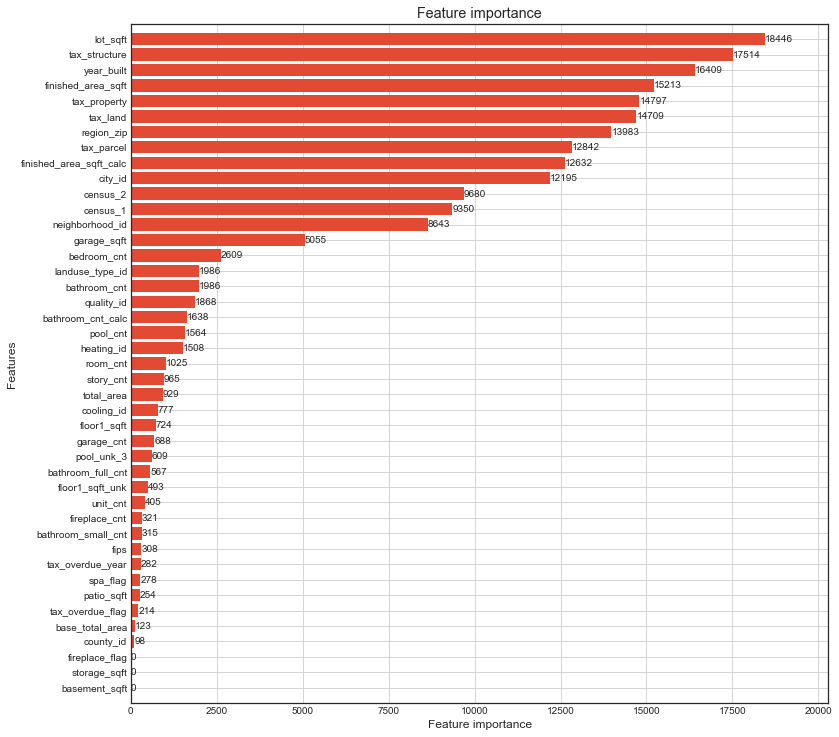

In [13]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [ ]:
def predict_and_export(clf, prop, file_name):
    # Construct features and make prediction
    test_features = drop_features(prop)
    pred_test = clf.predict(test_features)
    
    # Export prediction results
    submission = pd.DataFrame()
    submission['ParcelId'] = prop.parcelid
    
    pred_test = [float(format(x, '.4f')) for x in pred_test]
    test_columns = ['201610','201611','201612','201710','201711','201712']
    for col in test_columns:
        submission[col] = pred_test
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)

predict_and_export(clf, prop, 'data/submission_181228_v2.csv')

In [ ]:
# Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('cat_smooth', [5.0, 10.0, 15.0, 20.0])